# MarlimR3D - Comparison

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe

In [2]:
%matplotlib notebook

## Figure 4 from Correa and Menezes (2019), but noise-free data

In [3]:
def print_attributes(inp):
    """Print info from modeller."""
    for key in ['runtime', 'n_procs', 'max_ram',
                'n_cells', 'n_nodes', 'n_dof', 'extent',
                'min_vol', 'max_vol', 'machine',
                'version', 'date']:
        print(f"{key:10} : {inp.attrs[key]}")
        

def extract_line(d, n, b=None):
    """Extract lines from the nc-data."""
    data = getattr(d, n)
    data = abs(data.data[::2, :, :] + 1j*data.data[1::2, :, :])
    
    if b is not None:
        comp = getattr(b, n)
        comp = abs(comp.data[::2, :, :] + 1j*comp.data[1::2, :, :])
        
        data -= comp

    return data

## Published Marlim R3D data

In [4]:
data = xr.load_dataset('marlim_data.nc', engine='h5netcdf')

# Get offsets for plotting
offs = data.src_x[::2] - data.rec_x
offs /= 1e3

## Our results

In [5]:
egd = xr.load_dataset('results/marlim_emg3d.nc', engine='h5netcdf')
cst = xr.load_dataset('results/marlim_custEM_p2.nc', engine='h5netcdf')
ptg = xr.load_dataset('results/marlim_petgem.nc', engine='h5netcdf')
spg = xr.load_dataset('results/marlim_simpeg.nc', engine='h5netcdf')

for dat, name in zip([egd, cst, ptg, spg], ['emg3d', 'custEM', 'PETGEM', 'SimPEG']):
    print(f"\n= - = - =  : {name} {14*'= - '}=\n")
    print_attributes(dat)


= - = - =  : emg3d = - = - = - = - = - = - = - = - = - = - = - = - = - = - =

runtime    : 1200 s
n_procs    : 1
max_ram    : 0.546 GiB
n_cells    : (192 x 80 x 128) - 1966080
n_nodes    : N/A
n_dof      : 5998992
extent     : x = 327426.0-453624.0; y = 7464458.2-7570039.8; z = -56648.0-83814.0
min_vol    : 200000.0
max_vol    : 7961665640795.1
machine    : Laptop; i7-6600U CPU@2.6 GHz x4; 15.5 GiB of memory, Ubuntu 18.04
version    : emg3d v0.12.0
date       : 2020-09-11T08:59:22.925996

= - = - =  : custEM = - = - = - = - = - = - = - = - = - = - = - = - = - = - =

runtime    : 4984 s
n_procs    : 64
max_ram    : 558.5 GiB
n_cells    : 710625
n_nodes    : 118399
n_dof      : 9078948
extent     : x = -22800 - 22800; y = -22800 - 22800; z = -22800 - 22800
min_vol    : N/A
max_vol    : N/A
machine    : PowerEdge R940 server; 144 Xeon Gold 6154 CPU @2.666 GHz; ~3 TB DDR4 RAM; Ubuntu 18.04
version    : custEM v0.99.05
date       : 2020-04-03T13:14:24.066044

= - = - =  : PETGEM = - = - = 

## (1) Plot actual responses

<IPython.core.display.Javascript object>


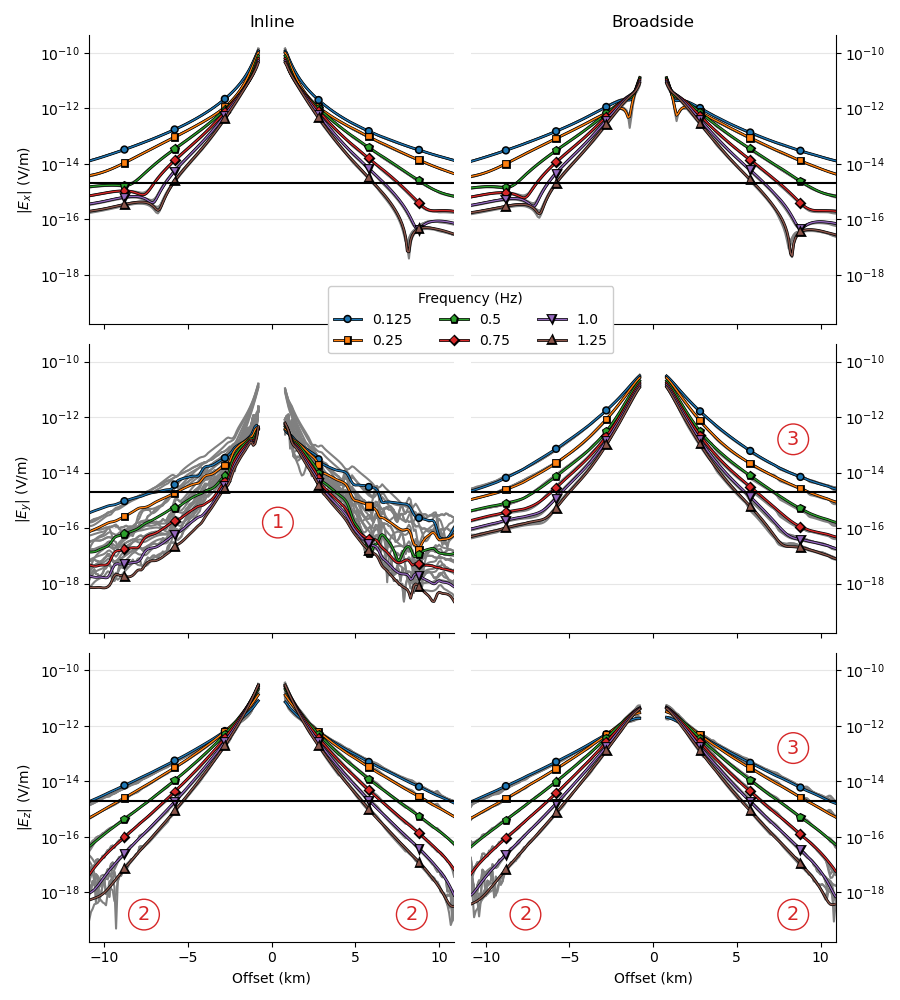

In [6]:
# Line styles for published data.
general = {'mec': 'k', 'mew': 0.2, 'lw': 1, 'markevery': (20, 30),
           'path_effects': [pe.Stroke(linewidth=2, foreground='k'), pe.Normal()]}
styles = {
    1.25: {'marker': '^', 'ms': 5, **general},
    1.0: {'marker': 'v', 'ms': 5, **general},
    0.75: {'marker': 'D', 'ms': 4, **general},
    0.5: {'marker': 'p', 'ms': 5, **general},
    0.25: {'marker': 's', 'ms': 4, **general},
    0.125: {'marker': 'o', 'ms': 4, **general},
}

# Initiate figure.
fig, axs = plt.subplots(3, 2, figsize=(9, 10), sharex=True, sharey=True)

# Loop over Inline/Broadside.
for iii, datname in enumerate(['data_il', 'data_bs']):

    # Get absolute values of this line.
    tdat = extract_line(data, datname)
    tegd = extract_line(egd, datname)
    tcst = extract_line(cst, datname)
    tptg = extract_line(ptg, datname)
    tspg = extract_line(spg, datname)

    # Loop over components Ex, Ey, Ez.
    for ii, comp in enumerate(data.components.values[:3]):

        # Get current axis.
        ax = axs[ii, iii]

        # Loop over frequencies for our codes.
        for i, freq in enumerate(data.freqs.values):

            # Loop over our codes.
            for ic, dat in enumerate([tegd, tcst, tptg, tspg]):
                ax.plot(offs[101::-1], dat[101::-1, i, ii], '.5')
                ax.plot(offs[102:], dat[102:, i, ii], '.5')

        # Loop over frequencies for published responses.
        for i, freq in enumerate(data.freqs.values):           
            ax.plot(offs[101::-1], tdat[101::-1, i, ii], f"C{i}", **styles[freq], label=f"{freq}")
            ax.plot(offs[102:], tdat[102:, i, ii], f"C{i}", **styles[freq])

        # Plot noise level.
        ax.axhline(2e-15, c='k')
        
        # Grid lines and yscale.
        ax.grid(axis='y', c='0.9')
        ax.set_yscale('log')
        
# Switch off spines and move ticks.
for ax in axs.ravel():
    ax.spines['top'].set_visible(False)
for ax in axs[:, 0].ravel():
    ax.spines['right'].set_visible(False)
for ax in axs[:, 1].ravel():
    ax.yaxis.set_ticks_position('right')
    ax.yaxis.set_label_position('right')
    ax.spines['left'].set_visible(False)

# Titles and labels.
axs[0, 0].set_title("Inline")
axs[0, 1].set_title("Broadside")
axs[2, 0].set_xlabel('Offset (km)')
axs[2, 1].set_xlabel('Offset (km)')
axs[0, 0].set_ylabel('$|E_x|$ (V/m)')
axs[1, 0].set_ylabel('$|E_y|$ (V/m)')
axs[2, 0].set_ylabel('$|E_z|$ (V/m)')

# Limits.
axs[0, 0].set_xlim([offs[0], offs[-1]])

# Annotate note-worthy points with numbers.
bbox = {'fontsize': 14, 'bbox': {"boxstyle" : "circle", 'ec': 'C3', 'fc': 'w'}}
axs[1, 1].annotate("3", (8, 1e-13), c='C3', **bbox)
axs[2, 1].annotate("3", (8, 1e-13), c='C3', **bbox)
axs[2, 0].annotate("2", (-8, 1e-19), c='C3', **bbox)
axs[2, 0].annotate("2", (8, 1e-19), c='C3', **bbox)
axs[2, 1].annotate("2", (-8, 1e-19), c='C3', **bbox)
axs[2, 1].annotate("2", (8, 1e-19), c='C3', **bbox)
axs[1, 0].annotate("1", (0, 1e-16), c='C3', **bbox)

# Tight layout.
fig.tight_layout()

# Add frequency legend.
axs[1, 1].legend(
    title='Frequency (Hz)', bbox_to_anchor=(0, 1.2),
    loc='upper center', borderaxespad=0., ncol=3, framealpha=1)

# Save and show.
fig.savefig(f'../manuscript/figures/results-marlim-responses.pdf', bbox_inches='tight')
fig.show()

## (2) Plot NRMSD with respect to published data

<IPython.core.display.Javascript object>


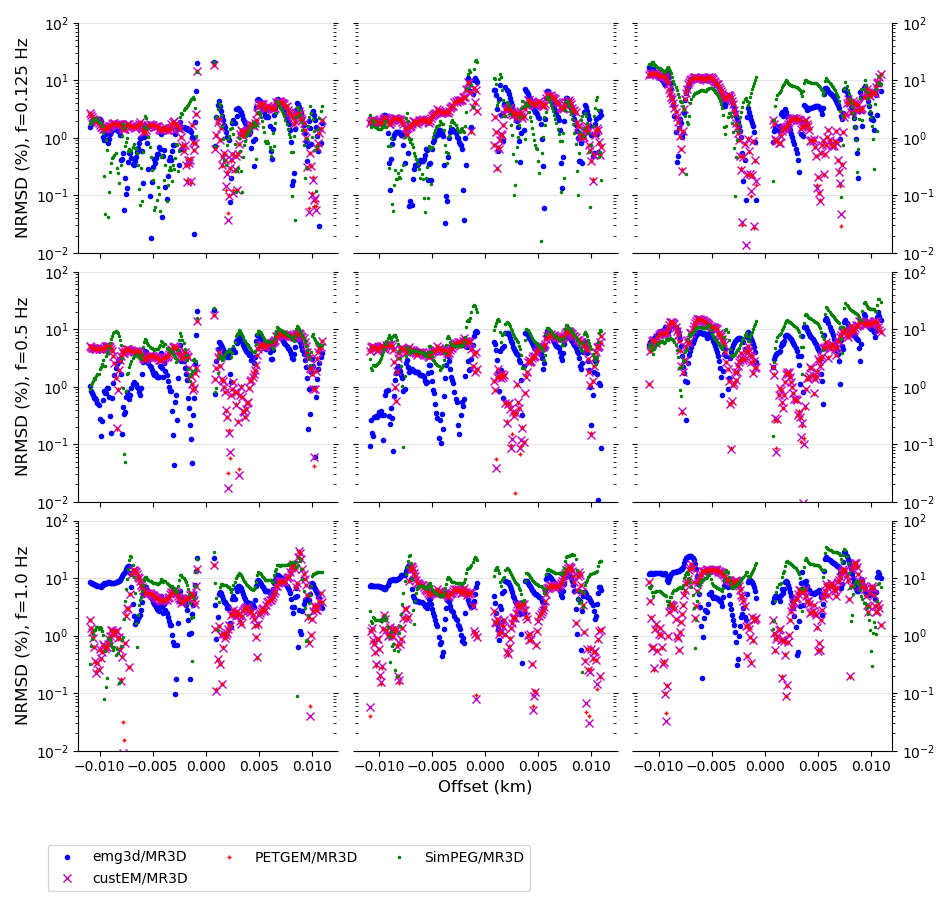

In [7]:
fs = 12
fig, axs = plt.subplots(3, 3, figsize=(9.5, 9), sharex=True)

ls = ['-', ':', '--']
ms = 8

# Loop over Inline/Broadside
for iii, datname in enumerate(['data_il', 'data_bs']):

    # Get absolute values of this line
    tdat = extract_line(data, datname)
    tegd = extract_line(egd, datname)
    tcst = extract_line(cst, datname)
    tptg = extract_line(ptg, datname)
    tspg = extract_line(spg, datname)

    # Loop over components Ex, Ey, Ez
    if datname == 'data_il':
        values = data.components.values[:1]  # Ex
    else:
        values = data.components.values[:2]  # Ex, Ey
        
    # Loop over frequencies
    for i, freq in enumerate(data.freqs.values[::2]):  # every 2nd
        
        # Error
        for ii, comp in enumerate(values):

            plt.sca(axs[i, ii+iii])

            # Plot difference
            dat_egd = 200*abs(tdat[:, i*2, ii]-tegd[:, i*2, ii])/(abs(tdat[:, i*2, ii])+abs(tegd[:, i*2, ii]))
            dat_cst = 200*abs(tdat[:, i*2, ii]-tcst[:, i*2, ii])/(abs(tdat[:, i*2, ii])+abs(tcst[:, i*2, ii]))
            dat_ptg = 200*abs(tdat[:, i*2, ii]-tptg[:, i*2, ii])/(abs(tdat[:, i*2, ii])+abs(tptg[:, i*2, ii]))
            dat_spg = 200*abs(tdat[:, i*2, ii]-tspg[:, i*2, ii])/(abs(tdat[:, i*2, ii])+abs(tspg[:, i*2, ii]))
            
            plt.plot(offs/1e3, dat_egd, 'b.', label="emg3d/MR3D" if i == 0 else None)
            plt.plot(offs/1e3, dat_cst, 'mx', label="custEM/MR3D" if i == 0 else None)
            plt.plot(offs/1e3, dat_ptg, 'r+', ms=3, label="PETGEM/MR3D" if i == 0 else None)
            plt.plot(offs/1e3, dat_spg, 'g.', ms=3, label="SimPEG/MR3D" if i == 0 else None)
            
            plt.grid(axis='y', c='0.9')
            plt.yscale('log')
            plt.ylim([1e-2, 1e2])
            if ii+iii == 2:
                axs[i, 2].yaxis.tick_right()
            axs[i, ii+iii].yaxis.set_ticks_position('both')

        axs[i, 0].set_ylabel(f'NRMSD (%), f={freq} Hz', fontsize=fs)
        axs[i, 1].set_yticklabels(())

    axs[2, 1].set_xlabel('Offset (km)', fontsize=fs)


# Switch off spines
for i in range(3):
    for ii in range(3):
        axs[i, ii].spines['top'].set_visible(False)
    for ii in range(2):
        axs[i, ii].spines['right'].set_visible(False)
    for ii in range(1, 3):
        axs[i, ii].spines['left'].set_visible(False)
        
plt.tight_layout(h_pad=0.02, rect=[0, 0.1, 1, 1])

plt.sca(axs[0, 0])
plt.legend(bbox_to_anchor=(0.05, 0.01), bbox_transform=fig.transFigure,
           loc='lower left', borderaxespad=0., ncol=3)  
                
plt.savefig(f'../manuscript/figures/results-marlim_2published.pdf', bbox_inches='tight')
plt.show()

## (3) Plot NRMSD with respect to each other

<IPython.core.display.Javascript object>


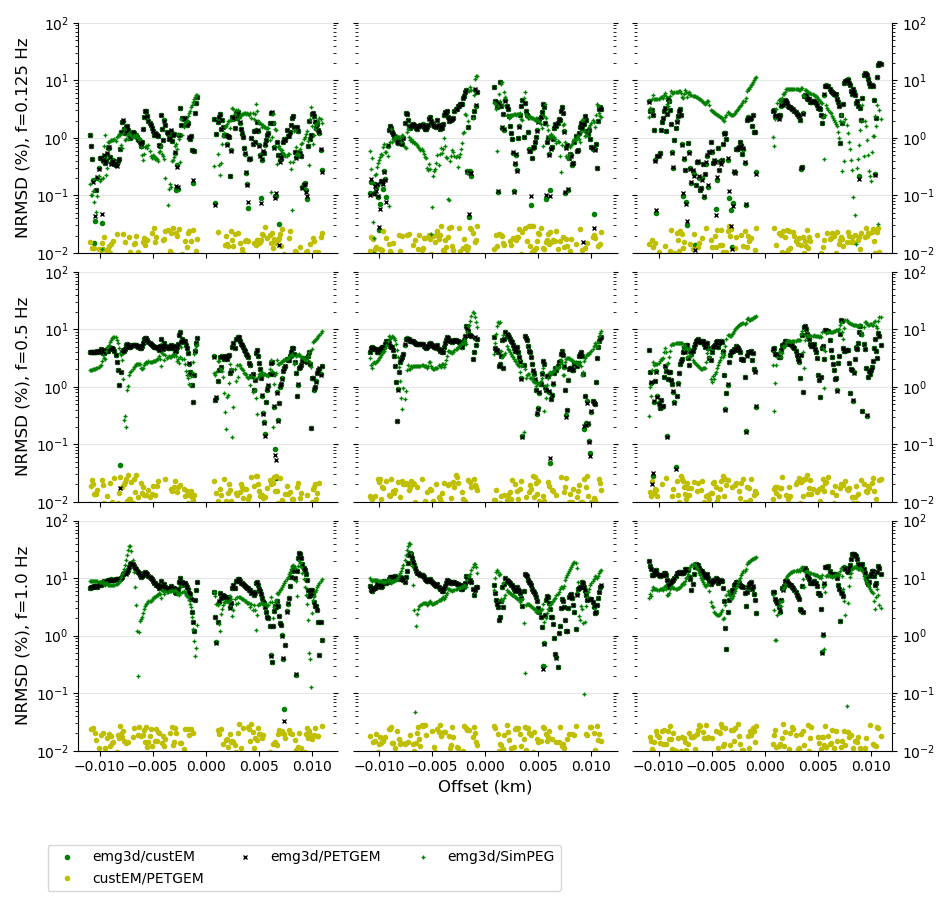

In [8]:
fs = 12
fig, axs = plt.subplots(3, 3, figsize=(9.5, 9), sharex=True)

ls = ['-', ':', '--']
ms = 8

# Loop over Inline/Broadside
for iii, datname in enumerate(['data_il', 'data_bs']):

    # Get absolute values of this line
    tdat = extract_line(data, datname)
    tegd = extract_line(egd, datname)
    tcst = extract_line(cst, datname)
    tptg = extract_line(ptg, datname)
    tspg = extract_line(spg, datname)

    # Loop over components Ex, Ey, Ez
    if datname == 'data_il':
        values = data.components.values[:1]  # Ex
    else:
        values = data.components.values[:2]  # Ex, Ey
        
    # Loop over frequencies
    for i, freq in enumerate(data.freqs.values[::2]):  # every 2nd

        # Error
        for ii, comp in enumerate(values):

            plt.sca(axs[i, ii+iii])

            # Plot difference            
            egd_cst = 200*abs(tegd[:, i*2, ii]-tcst[:, i*2, ii])/(abs(tegd[:, i*2, ii])+abs(tcst[:, i*2, ii]))
            cst_ptg = 200*abs(tcst[:, i*2, ii]-tptg[:, i*2, ii])/(abs(tcst[:, i*2, ii])+abs(tptg[:, i*2, ii]))
            egd_ptg = 200*abs(tegd[:, i*2, ii]-tptg[:, i*2, ii])/(abs(tegd[:, i*2, ii])+abs(tptg[:, i*2, ii])) 
            egd_spg = 200*abs(tegd[:, i*2, ii]-tspg[:, i*2, ii])/(abs(tegd[:, i*2, ii])+abs(tspg[:, i*2, ii]))  
                        
            plt.plot(offs/1e3, egd_cst, 'g.', label="emg3d/custEM" if i == 0 else None)
            plt.plot(offs/1e3, cst_ptg, 'y.', label="custEM/PETGEM" if i == 0 else None)
            plt.plot(offs/1e3, egd_ptg, 'kx', ms=3, label="emg3d/PETGEM" if i == 0 else None)
            plt.plot(offs/1e3, egd_spg, 'g+', ms=3, label="emg3d/SimPEG" if i == 0 else None)

            plt.grid(axis='y', c='0.9')
            plt.yscale('log')
            plt.ylim([1e-2, 1e2])
            if ii+iii == 2:
                axs[i, 2].yaxis.tick_right()
            axs[i, ii+iii].yaxis.set_ticks_position('both')

        axs[i, 0].set_ylabel(f'NRMSD (%), f={freq} Hz', fontsize=fs)
        axs[i, 1].set_yticklabels(())

    axs[2, 1].set_xlabel('Offset (km)', fontsize=fs)


# Switch off spines
for i in range(3):
    for ii in range(3):
        axs[i, ii].spines['top'].set_visible(False)
    for ii in range(2):
        axs[i, ii].spines['right'].set_visible(False)
    for ii in range(1, 3):
        axs[i, ii].spines['left'].set_visible(False)
        
plt.tight_layout(h_pad=0.02, rect=[0, 0.1, 1, 1])

plt.sca(axs[0, 0])
plt.legend(bbox_to_anchor=(0.05, 0.01), bbox_transform=fig.transFigure,
           loc='lower left', borderaxespad=0., ncol=3)  
                
plt.savefig(f'../manuscript/figures/results-marlim_2ours.pdf', bbox_inches='tight')
plt.show()

In [9]:
import scooby
scooby.Report(['xarray', 'h5netcdf'])

--------------------------------------------------------------------------------
  Date: Tue Sep 15 21:07:56 2020 CEST

                OS : Linux
            CPU(s) : 4
           Machine : x86_64
      Architecture : 64bit
               RAM : 7.7 GB
       Environment : Jupyter

  Python 3.8.5 | packaged by conda-forge | (default, Aug 29 2020, 01:22:49)
  [GCC 7.5.0]

            xarray : 0.16.0
          h5netcdf : 0.8.1
             numpy : 1.19.1
             scipy : 1.5.2
           IPython : 7.18.1
        matplotlib : 3.3.1
            scooby : 0.5.6
--------------------------------------------------------------------------------